## This notebook has 5 coding questions based on langgraph.

In [1]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("groq_key")


In [2]:
! pip install langchain langgraph langchain-groq langchain_community

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.2/152.2 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.1/131.1 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.8/442.8 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 9.1 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.66
    Uninstalling langchain-core-0.3.66:
      Successfully uninstalled langchain-core-0.3.66


In [3]:
import os
if not os.environ.get("GROQ_API_KEY"):
    os.environ["GROQ_API_KEY"] = secret_value_0

from langchain.chat_models import init_chat_model
llm = init_chat_model(model = "llama3-8b-8192", model_provider="groq")

## Question 1: 
Write a simple LangGraph with two nodes:

* A user_input node that accepts a string.

* A llm_response node that uses Groq to generate a response based on the input.

The flow should:

* Start from user_input → go to llm_response → and return the final result.

📌 Constraints:

* Input should be "Tell me a joke".

In [4]:
from langchain_core.prompts import PromptTemplate
prompt = PromptTemplate(
    input_variables = ['input'],
    template = "Reply to this query.\n\n{input}"
)

In [5]:
from typing_extensions import TypedDict
from langgraph.graph import START,StateGraph
class State(TypedDict):
    question: str
    result: str


def user_input(state:State):
    """Takes user input"""
    input_str = "Tell me a joke"
    user_prompt = prompt.format(input=input_str)
    return {"question":user_prompt}

def llm_response(state:State):
    """LLM responding to the question"""
    response = llm.invoke(state['question'])
    return {"result":response.content}

graph_builder = StateGraph(State).add_sequence([user_input,llm_response])
graph_builder.add_edge(START,"user_input")
graph = graph_builder.compile()

In [6]:
final_result = graph.invoke({})
print(final_result['result'])

Here's one:

Why don't scientists trust atoms?

Because they make up everything!

Hope that made you laugh!


# Question 2:
You are building a LangGraph that translates a sentence from English to French using Groq's llama3-8b-8192 model.
You need to build a 3-node graph:

* A node to accept English input from the user.

* A node to create a prompt for translation.

* A node that gets the translated French sentence from the LLM.

In [7]:
from typing_extensions import TypedDict
class State(TypedDict):
    """Defining State for our graph"""
    question: str
    prompt: str
    result: str

def inputs(state:State) -> State:
    """This input formats input."""
    inputs = "Where is the nearest train station?"
    return {"question":inputs}

def create_prompts(state:State) -> State:
    """Generates prompt."""
    prompt = f"Translate this sentence into French:\n\n{state['question']}"
    return {"prompt": prompt}

def translate_to_French(state:State) -> State:
    """Return French translation of English sentence."""
    result = llm.invoke(state['prompt'])
    return {"result": result.content}

graph_builder = StateGraph(State).add_sequence([inputs,create_prompts,translate_to_French])
graph_builder.add_edge(START,"inputs")
graph = graph_builder.compile()

graph.invoke({})

{'question': 'Where is the nearest train station?',
 'prompt': 'Translate this sentence into French:\n\nWhere is the nearest train station?',
 'result': 'Où est la gare de train la plus proche?\n\nHere\'s a breakdown of the translation:\n\n* "Where" is translated to "Où"\n* "is" is implied, as it\'s a question about the location of something\n* "the" is translated to "la" (since the nearest train station is a singular, feminine noun)\n* "nearest" is translated to "la plus proche" (using the superlative form of "proche", which means "near" or "close")\n* "train station" is translated to "gare de train"'}

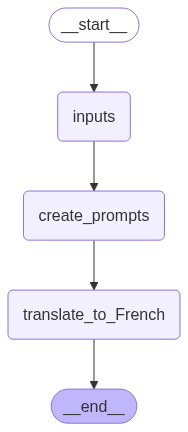

In [8]:
from IPython.display import display,Image
display(Image(graph.get_graph().draw_mermaid_png()))

### Question 3:

You're building a LangGraph workflow that uses LangChain tools.

You want to:

* Accept a user's question (e.g., "Show me all employees in the Sales department"),

* Generate a SQL query from it using an LLM,

* Execute the SQL query using a tool (QuerySQLDatabaseTool), and

* Return the final result.

In [9]:
from langchain_community.utilities import SQLDatabase
db=SQLDatabase.from_uri("sqlite:////kaggle/input/chinook/Chinook_Sqlite.sqlite")
print(db.dialect)
print(db.get_usable_table_names())


sqlite
['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']


In [10]:
from typing_extensions import TypedDict, Annotated
class State(TypedDict):
    question: str
    query: str
    query_result: str
    result:str

    

In [11]:
from langchain_core.prompts import ChatPromptTemplate
system="""Given an input question, create a syntactically correct {dialect} query to
run to help find the answer. Unless the user specifies in his question a
specific number of examples they wish to obtain, always limit your query to
at most {top_k} results. You can order the results by a relevant column to
return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the
few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema
description. Be careful to not query for columns that do not exist. Also,
pay attention to which column is in which table.

Only use the following tables:
{table_info}
"""
human = "Question:{question}"

chat = ChatPromptTemplate(
    [("system",system),("user",human)]
)
for message in chat.messages:
    message.pretty_print()



class QueryOutput(TypedDict):
    """Query Output"""
    query: Annotated[str,...,"Syntactically valid SQL query"]

def generate_query(state:State)->State:
    """Genrate SQL Query"""
    prompt = chat.invoke(
        {
            "dialect":db.dialect,
            "top_k":8,
            "table_info":db.get_table_info(),
            "question":state["question"]
        }
    )
    structured_llm = llm.with_structured_output(QueryOutput)
    result = structured_llm.invoke(prompt)
    return {"query":result["query"]}


================================ System Message ================================

Given an input question, create a syntactically correct {dialect} query to
run to help find the answer. Unless the user specifies in his question a
specific number of examples they wish to obtain, always limit your query to
at most {top_k} results. You can order the results by a relevant column to
return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the
few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema
description. Be careful to not query for columns that do not exist. Also,
pay attention to which column is in which table.

Only use the following tables:
{table_info}

================================ Human Message =================================

Question:{question}


In [12]:
ques = "How many Playlists are there?"
generate_query({"question":ques})

{'query': 'SELECT COUNT(*) FROM Playlist;'}

In [13]:
from langchain_community.tools.sql_database.tool import QuerySQLDatabaseTool
def execute_query(state:State)->State:
    "Running the query"
    execute_query_tool = QuerySQLDatabaseTool(db=db)
    return {"query_result":execute_query_tool.invoke(state["query"])}

In [14]:
execute_query({'query': 'SELECT COUNT(DISTINCT ArtistId) FROM Artist'})

{'query_result': '[(275,)]'}

In [15]:
def generate_answer(state:State)->State:
    """Generate answer based on query and query_result"""
    prompt = ("Given the following user question, corresponding to a SQL query, "
    "and SQL query result, answer the user question based on SQL query and SQL query result.\n\n"
    f"Question: {state['question']}\n"
    f"SQL Query:{state['query']}\n"
    f"SQL Query result: {state['query_result']}")
    result = llm.invoke(prompt)
    return {"result":result.content}

In [16]:
from langgraph.graph import StateGraph, START
graph_builder = StateGraph(State).add_sequence([generate_query,execute_query,generate_answer])
graph_builder.add_edge(START,"generate_query")
graph = graph_builder.compile()

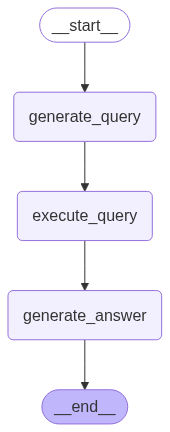

In [17]:
from IPython.display import Image,display
display(Image(graph.get_graph().draw_mermaid_png()))

In [18]:
for step in graph.stream(
    {"question": "how many artists are there"}, stream_mode="updates"
):
    
    print(step)

{'generate_query': {'query': 'SELECT COUNT(DISTINCT ArtistId) FROM Artist'}}
{'execute_query': {'query_result': '[(275,)]'}}
{'generate_answer': {'result': 'Based on the SQL query result [(275,)], the answer to the user question "how many artists are there" is:\n\nThere are **275** artists.'}}


# Question 4:
You are building a text summarization workflow using LangGraph.

The steps are:

**Input:** Take a paragraph of text from the user.

**Prompt:** Format a prompt like:
"Please summarize the following passage:\n\n{text}"

**LLM Call:** Use Groq + LLaMA3 to generate the summary.

**Output:** Return the final summarized result.



In [19]:
#Using langchain
text = """Our solar system includes the Sun, eight planets, five officially named dwarf planets, 
hundreds of moons, and thousands of asteroids and comets.Our solar system is located in the Milky Way, 
a barred spiral galaxy with two major arms, and two minor arms. Our Sun is in a small, partial arm of the
Milky Way called the Orion Arm, or Orion Spur, between the Sagittarius and Perseus arms. Our solar system orbits 
the center of the galaxy at about 515,000 mph (828,000 kph). It takes about 230 million years to complete one orbit 
around the galactic center."""
prompt = PromptTemplate.from_template("You will be given a paragraph. You will have to summarize that paragraph in not more than 3 lines. Here is the paragraph:\n\n {text}")
formatted_prompt = prompt.format(text=text)
result = llm.invoke(formatted_prompt)
output = result.content
print(output)

Here is a summary of the paragraph in 3 lines:

Our solar system contains the Sun, 8 planets, 5 dwarf planets, hundreds of moons, and thousands of asteroids and comets. It is located in the Milky Way galaxy, specifically in the Orion Arm, and orbits the center of the galaxy at 515,000 mph. It takes approximately 230 million years to complete one orbit around the galactic center.


In [20]:
#Using langgraph

class State(TypedDict):
    initial_text: str
    prompt: str
    result: str


text =  """Our solar system includes the Sun, eight planets, five officially named dwarf planets, 
hundreds of moons, and thousands of asteroids and comets.Our solar system is located in the Milky Way, 
a barred spiral galaxy with two major arms, and two minor arms. Our Sun is in a small, partial arm of the
Milky Way called the Orion Arm, or Orion Spur, between the Sagittarius and Perseus arms. Our solar system orbits 
the center of the galaxy at about 515,000 mph (828,000 kph). It takes about 230 million years to complete one orbit 
around the galactic center."""

def define_prompt(state:State):
    prompt = PromptTemplate.from_template("You will be given a paragraph. You will have to summarize that paragraph in not more than 3 lines. Here is the paragraph:\n\n {text}")
    formatted_prompt = prompt.format(text=state['initial_text'])
    return {"prompt":formatted_prompt}
    
def summarize(state:State):
    answer = llm.invoke(state['prompt'])
    return {"result":answer.content}


from langgraph.graph import StateGraph, START
graph_builder = StateGraph(State).add_sequence([define_prompt,summarize])
graph_builder.add_edge(START,"define_prompt")
graph = graph_builder.compile()

answer = graph.invoke({"initial_text":text})
answer

{'initial_text': 'Our solar system includes the Sun, eight planets, five officially named dwarf planets, \nhundreds of moons, and thousands of asteroids and comets.Our solar system is located in the Milky Way, \na barred spiral galaxy with two major arms, and two minor arms. Our Sun is in a small, partial arm of the\nMilky Way called the Orion Arm, or Orion Spur, between the Sagittarius and Perseus arms. Our solar system orbits \nthe center of the galaxy at about 515,000 mph (828,000 kph). It takes about 230 million years to complete one orbit \naround the galactic center.',
 'prompt': 'You will be given a paragraph. You will have to summarize that paragraph in not more than 3 lines. Here is the paragraph:\n\n Our solar system includes the Sun, eight planets, five officially named dwarf planets, \nhundreds of moons, and thousands of asteroids and comets.Our solar system is located in the Milky Way, \na barred spiral galaxy with two major arms, and two minor arms. Our Sun is in a small,